In [13]:
import cv2
import numpy as np 
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt
from heapq import *
import os 

In [4]:
def drushti(img,enhance):
    """Image read as grayscale, 
    appling median blur for noise removal,
    binarizing image using sauvola thresholding and inverting it"""
    filename = img
    img = cv2.imread(img,0)
    img = cv2.medianBlur(img, 3)
    window_size=15
    thresh_sauvola = threshold_sauvola(img, window_size=window_size)
    binary_sauvola = img > thresh_sauvola
    im = (binary_sauvola*255).astype(np.uint8)
    im = im.copy()
    im = abs(255-im)
    im = im/255
#     plt.imshow(im,cmap="gray")
    if enhance==True:
        """Applying morphological operations """
        kernel = np.ones((3, 3), np.uint8)
        im = cv2.erode(im, kernel, iterations=2)
        kernel = np.ones((3, 3), np.uint8)
        im = cv2.dilate(im, kernel, iterations=3)
    horizontal = np.sum(im, axis=1) 
    peaks_index = find_peak_regions(horizontal)
    try:
        clusters = get_clusters(peaks_index)
        for cluster_of_interest in clusters:
            nmap = im[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
            blocks = get_block_regions(nmap)
            blocks_cluster_groups=get_clusters(blocks)

            for index, blocks in enumerate(blocks_cluster_groups):           
                window = nmap[:, blocks[0]: blocks[1]+10]
                im[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, blocks[0]:blocks[1]+10][int(window.shape[0]/2),:] *= 0
    except IndexError:
        pass
    line_segments = []
    lens = 0
    for l in clusters:lens+=len(l)
    avglen = int(lens/len(clusters))
    print("Average cluster len ",avglen)
    for i, cluster_of_interest in enumerate(clusters):
    
        if len(cluster_of_interest) >avglen:  ##WHY 10? minimum lettersize
            nmap = im[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
            path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
            #path = np.array(astar(nmap, (0, 0), (0,nmap.shape[1]-1)))
            offset_from_top = cluster_of_interest[0]
            if path.shape[0]>1:
                path[:,0] += offset_from_top
                line_segments.append(path)
    img =cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    for path in line_segments:
        for index, item in enumerate(path): 
            if index == len(path) -1:break
            cv2.line(img, (item[1],item[0]),(path[index + 1][1],path[index + 1][0]), [0, 255, 0], 2) 
    return img


In [16]:
def get_clusters(peaks_index):
    clusters = []
    minclus = []
    for i in range(len(peaks_index)):
        if i+1==len(peaks_index):
            if len(minclus):
                if peaks_index[i]-minclus[-1] <2:
                    minclus.append(peaks_index[i])
                    clusters.append(minclus)
                else:
                    clusters.append(minclus)
                    minclus = []
                    clusters.append(minclus.append(peaks_index[i]))
            else:
                clusters.append(minclus.append(peaks_index[i]))
            break
        if (peaks_index[i+1] - peaks_index[i])<2:
            minclus.append(peaks_index[i])
        else:
            minclus.append(peaks_index[i])
            clusters.append(minclus)
            minclus=[]
    return clusters
def find_peak_regions(hpp, divider=9):
    threshold =(np.max(hpp)-np.min(hpp))/divider
    print(threshold)
    peaks = []
    peaks_index = []
    print(threshold)
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append(i)
    return peaks

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

#a star path planning algorithm
def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    print(gscore)
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []
def path_exists(window):
    #very basic check first then proceed to A* check
    if 0 in np.sum(window, axis=1):
        return True
    
    padded_window = np.zeros((window.shape[0],1))
    chunk = np.hstack((padded_window, np.hstack((window,padded_window)) ) )
    path = np.array(astar(chunk, (int(chunk.shape[0]/2), 0), (int(chunk.shape[0]/2), chunk.shape[1])))
    if len(path) > 0:
        return True
    
    return False
def get_block_regions(nmap):
    blocks = []
    needtobreak = False
    
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True

        if path_exists(nmap[:, start:end]) == False:
            blocks.append(col)

        if needtobreak == True:
            break
            
    return blocks

115.22222222222223
115.22222222222223
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(1, 0): 0}
{(

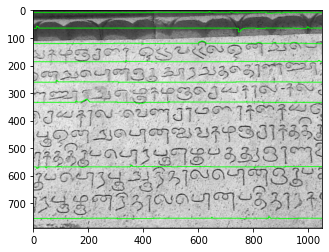

In [17]:
filename = "data_totry/PGY_11.jpg"
img = drushti(filename,False)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
filename = os.path.splitext(filename)[0]+"_output.png"
cv2.imwrite(filename,img)
print("Done")